

<p><img height="80px" src="https://www.upm.es/sfs/Rectorado/Gabinete%20del%20Rector/Logos/UPM/Escudo/EscUpm.jpg" align="left" hspace="3px" vspace="3px"></p>

**Course "Artificial Neural Networks and Deep Learning" - Universidad Politécnica de Madrid (UPM)**

# **Hands-on Project 2 - Deep Q-Learning for Lunar Lander**
This notebook includes an implementation of the Deep Q-learning (DQN) algorithm for the LunarLander (see [OpenAI's LunarLander](https://www.gymlibrary.dev/environments/box2d/lunar_lander/)).

- Iago Zamorano Chouciño (iago.zamorano@alumnos.upm.es)
- Íñigo Sánchez Rodríguez (i.rsanchez@alumnos.upm.es)
- Markel Tyan Tyan (markel.tyan@alumnos.upm.es)

## Libraries

In [ ]:
#%pip install gym
#%pip install box2d-py
#%pip install gym[box2d]
#%conda install -c conda-forge box2d-py 
#%pip install gym pyvirtualdisplay --quiet
#%pip install pygame
#%pip install tensorflow
#%pip install matplotlib
#%pip install pyglet --quiet

import gym
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay
import time
import random

## Hyperparameters

Aquí podemos ver los hiperparámetros utilizados para nuestro modelo. Se ha utilizado un batch de 64, una caida de exploración de 0.996 y un ratio de aprendizaje de 0.0005 para mejor adaptabilidad a este problema, ya que se ha notado un cierto sobreaprendizaje en las ejecuciones anteriores. Además, se ha utilizado un máximo de 1000 episodios para intentar que no sea la condición de parada principal.

In [ ]:
GAMMA = 0.99
MEMORY_SIZE = 1000000
LEARNING_RATE = 0.0005
BATCH_SIZE = 64
EXPLORATION_MAX = 1
EXPLORATION_MIN = 0.01
EXPLORATION_DECAY = 0.996
NUMBER_OF_EPISODES = 1000

## Class ReplayMemory

Memory of transitions for experience replay.

In [ ]:
class ReplayMemory:

    def __init__(self,number_of_observations):
        # Create replay memory
        self.states = np.zeros((MEMORY_SIZE, number_of_observations))
        self.states_next = np.zeros((MEMORY_SIZE, number_of_observations))
        self.actions = np.zeros(MEMORY_SIZE, dtype=np.int32)
        self.rewards = np.zeros(MEMORY_SIZE)
        self.terminal_states = np.zeros(MEMORY_SIZE, dtype=bool)
        self.current_size=0

    def store_transition(self, state, action, reward, state_next, terminal_state):
        # Store a transition (s,a,r,s') in the replay memory
        i = self.current_size
        self.states[i] = state
        self.states_next[i] = state_next
        self.actions[i] = action
        self.rewards[i] = reward
        self.terminal_states[i] = terminal_state
        self.current_size = i + 1

    def sample_memory(self, batch_size):
        # Generate a sample of transitions from the replay memory
        batch = np.random.choice(self.current_size, batch_size)
        states = self.states[batch]
        states_next = self.states_next[batch]
        rewards = self.rewards[batch]
        actions = self.actions[batch]   
        terminal_states = self.terminal_states[batch]  
        return states, actions, rewards, states_next, terminal_states

## Class DQN

Reinforcement learning agent with a Deep Q-Network.

In [ ]:
class DQN:

    def __init__(self, number_of_observations, number_of_actions):
        # Initialize variables and create neural model
        self.exploration_rate = EXPLORATION_MAX
        self.number_of_actions = number_of_actions
        self.number_of_observations = number_of_observations
        self.scores = []
        self.memory = ReplayMemory(number_of_observations)
        self.model = keras.models.Sequential()
        self.model.add(keras.layers.Dense(150, input_shape=(number_of_observations,), \
                             activation="relu",kernel_initializer="he_normal"))
        self.model.add(keras.layers.Dense(150, activation="relu",kernel_initializer="he_normal"))
        self.model.add(keras.layers.Dense(number_of_actions, activation="linear"))
        self.model.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE))

    def remember(self, state, action, reward, next_state, terminal_state):
        # Store a tuple (s, a, r, s') for experience replay
        state = np.reshape(state, [1, self.number_of_observations])
        next_state = np.reshape(next_state, [1, self.number_of_observations])
        self.memory.store_transition(state, action, reward, next_state, terminal_state)

    def select(self, state):
        # Generate an action for a given state using epsilon-greedy policy
        if np.random.rand() < self.exploration_rate:
            return random.randrange(self.number_of_actions)
        else:
            state = np.reshape(state, [1, self.number_of_observations])
            q_values = self.model.predict(state, verbose=0)
            return np.argmax(q_values[0])

    def learn(self):
        # Learn the value Q using a sample of examples from the replay memory
        if self.memory.current_size < BATCH_SIZE: return

        states, actions, rewards, next_states, terminal_states = self.memory.sample_memory(BATCH_SIZE)

        q_targets = self.model.predict(states, verbose=0)
        q_next_states = self.model.predict(next_states, verbose=0)

        for i in range(BATCH_SIZE):
             if (terminal_states[i]):
                  q_targets[i][actions[i]] = rewards[i]
             else:
                  q_targets[i][actions[i]] = rewards[i] + GAMMA * np.max(q_next_states[i])    

        self.model.train_on_batch(states, q_targets)

        # Decrease exploration rate
        self.exploration_rate *= EXPLORATION_DECAY
        self.exploration_rate = max(EXPLORATION_MIN, self.exploration_rate)

    def add_score(self, score):
       # Add the obtained score in a list to be presented later
        self.scores.append(score)

    def display_scores_graphically(self):
        # Display the obtained scores graphically
        plt.plot(self.scores)
        plt.xlabel("Episode")
        plt.ylabel("Score")            

## Environment Lunar Lander

Lunar Landing simulator from Open Ai Gym:

<p><img height="200px" src="https://www.gymlibrary.dev/_images/lunar_lander.gif" align="center" vspace="20px"</p>

**State vector**:
- state[0]: position x
- state[1]: position y
- state[2]: velocity x
- state[3]: velocity y
- state[4]: angle
- state[5]: angular velocity
- state[6]: leg 0 in contact 
- state[7]: leg 1 in contact

**Actions**:
- 0 (do nothing)
- 1 (fire left orientation engine)
- 2 (fire main engine)
- 3 (fire right orientation engine)

End of episode (**terminal states**):
- vehicle crashes (failure)
- Vehicle lands (success or failure)

Para esta practica se ha cogido como base el modelo de cartpole y se ha adaptado este mismo al agente LunarLander. En este modelo hemos utilizado dos capas ocultas y 150 neuronas por cada capa oculta, porque tiene mas caracteristicas y acciones que el cartpol volviendo mucho mas complejo. 
Por otro lado hemos utilizado como criterio de para la media de los ultimos 10 episodios, ya que si solo utilizamos el reward del ultimo episodio se puede llegar a una parada prematura. Es posible alcanzar la máxima puntuación por suerte y no estar la red entrenada debidamente. Por tanto con la puntuación de los últimos 10 episodios mayor a 200 nos aseguramos de que la red ha aprendido suficiente. Hay que decir que se podría utilizar un numero mayor para un grado de fiabilidad más alto, pero siendo el coste de la ejecución tan alto hemos decidido no probarlo de momento.

In [ ]:
def create_environment():
    # Create simulated environment
    environment = gym.make("LunarLander-v2") #agente LunarLander-v2
    number_of_observations = environment.observation_space.shape[0]
    number_of_actions = environment.action_space.n
    return environment, number_of_observations, number_of_actions

## Main program




/usr/local/lib/python3.8/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


Episode   1: avg score   0 last score -320.29262055554136 (exploration rate: 1.00, transitions: 64)
Episode   2: avg score   0 last score -92.87723880183715 (exploration rate: 0.77, transitions: 128)
Episode   3: avg score   0 last score -425.7407555596743 (exploration rate: 0.45, transitions: 261)
Episode   4: avg score   0 last score 197.10392898499242 (exploration rate: 0.07, transitions: 716)
Episode   5: avg score   0 last score -570.3585497627678 (exploration rate: 0.05, transitions: 801)
Episode   6: avg score   0 last score -180.67888802643893 (exploration rate: 0.02, transitions: 1076)
Episode   7: avg score   0 last score -246.42504918509678 (exploration rate: 0.01, transitions: 1207)
Episode   8: avg score   0 last score -121.32337248803518 (exploration rate: 0.01, transitions: 1386)
Episode   9: avg score   0 last score -341.9555242166273 (exploration rate: 0.01, transitions: 1546)


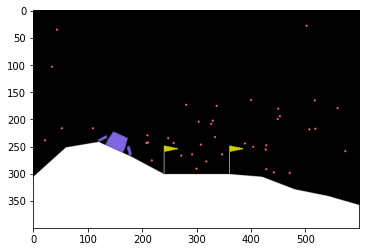

Episode  10: avg score -221.04825151021618 last score -107.93444549113568 (exploration rate: 0.01, transitions: 1656)
Episode  11: avg score -198.1063399139606 last score -90.87350459298546 (exploration rate: 0.01, transitions: 2656)
Episode  12: avg score -198.76225941152413 last score -99.4364337774724 (exploration rate: 0.01, transitions: 3656)
Episode  13: avg score -165.0666814667938 last score -88.78497611237125 (exploration rate: 0.01, transitions: 4656)
Episode  14: avg score -210.27435881114616 last score -254.97284445853103 (exploration rate: 0.01, transitions: 5606)
Episode  15: avg score -164.33680479360157 last score -110.98300958732173 (exploration rate: 0.01, transitions: 6606)
Episode  16: avg score -156.60261027022437 last score -103.33694279266705 (exploration rate: 0.01, transitions: 6936)
Episode  17: avg score -154.42165013835634 last score -224.61544786641645 (exploration rate: 0.01, transitions: 7139)
Episode  18: avg score -169.1377837450522 last score -268.4847

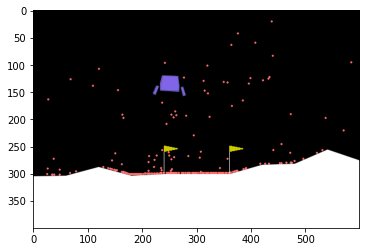

Episode  20: avg score -141.21763679497786 last score -66.2861845005656 (exploration rate: 0.01, transitions: 9022)
Episode  21: avg score -143.0225258474683 last score -108.92239511788978 (exploration rate: 0.01, transitions: 10022)
Episode  22: avg score -137.25640323249243 last score -41.775207627714 (exploration rate: 0.01, transitions: 11022)
Episode  23: avg score -143.5942315077844 last score -152.163258865291 (exploration rate: 0.01, transitions: 11347)
Episode  24: avg score -151.4713287144443 last score -333.74381652512994 (exploration rate: 0.01, transitions: 12213)
Episode  25: avg score -133.46841198156136 last score 69.04615774150759 (exploration rate: 0.01, transitions: 13213)
Episode  26: avg score -180.471419079506 last score -573.3670137721135 (exploration rate: 0.01, transitions: 13499)
Episode  27: avg score -165.89082324112186 last score -78.80948948257486 (exploration rate: 0.01, transitions: 13669)
Episode  28: avg score -136.79766174816615 last score 22.44690637

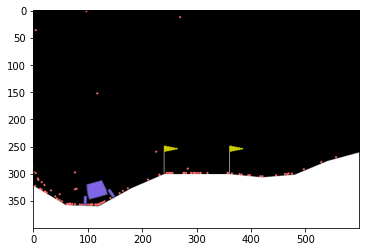

Episode  30: avg score -89.56391250697448 last score 150.26032101086227 (exploration rate: 0.01, transitions: 16362)
Episode  31: avg score -83.5744350737472 last score -49.02762078561687 (exploration rate: 0.01, transitions: 17362)
Episode  32: avg score -59.02859057685423 last score 203.6832373412156 (exploration rate: 0.01, transitions: 17813)
Episode  33: avg score -65.13876376566732 last score -213.26499075342178 (exploration rate: 0.01, transitions: 18090)
Episode  34: avg score -32.69059162166041 last score -9.262095085060949 (exploration rate: 0.01, transitions: 18255)
Episode  35: avg score -57.41842481749465 last score -178.2321742168349 (exploration rate: 0.01, transitions: 18497)
Episode  36: avg score 7.62286077734926 last score 77.04584217632569 (exploration rate: 0.01, transitions: 19497)
Episode  37: avg score 19.7106824243601 last score 42.068726987533545 (exploration rate: 0.01, transitions: 20497)
Episode  38: avg score 28.077128705774367 last score 106.1113691887062

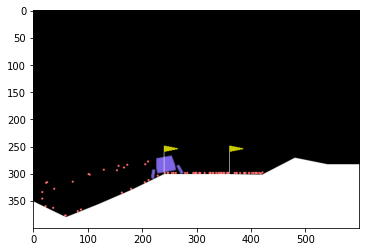

Episode  40: avg score 20.139753713307584 last score 170.0845640241071 (exploration rate: 0.01, transitions: 23123)
Episode  41: avg score -4.01242277761215 last score -290.54938569481425 (exploration rate: 0.01, transitions: 23495)
Episode  42: avg score 1.1624758562447197 last score 255.43222367978427 (exploration rate: 0.01, transitions: 23748)
Episode  43: avg score 45.4668551734501 last score 229.77880241863204 (exploration rate: 0.01, transitions: 24311)
Episode  44: avg score 43.40098096875764 last score -29.920837131985564 (exploration rate: 0.01, transitions: 24643)
Episode  45: avg score 85.5715224038407 last score 243.4732401339959 (exploration rate: 0.01, transitions: 25047)
Episode  46: avg score 78.95337836652133 last score 10.864401803131997 (exploration rate: 0.01, transitions: 25143)
Episode  47: avg score 98.61782677542031 last score 238.71321107652327 (exploration rate: 0.01, transitions: 25457)
Episode  48: avg score 113.90362876337159 last score 258.96938906821885 

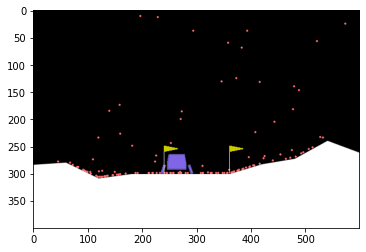

Episode  50: avg score 132.8543454774782 last score 241.9216151375677 (exploration rate: 0.01, transitions: 26772)
Episode  51: avg score 191.31771924890953 last score 294.08435201949914 (exploration rate: 0.01, transitions: 26959)
Episode  52: avg score 192.82642584069998 last score 270.5192895976887 (exploration rate: 0.01, transitions: 27205)
Episode  53: avg score 191.4933532920977 last score 216.4480769326092 (exploration rate: 0.01, transitions: 28080)
Episode  54: avg score 217.12146354498768 last score 226.3602653969141 (exploration rate: 0.01, transitions: 28521)
Reached goal successfully.
Time: 73 minutes


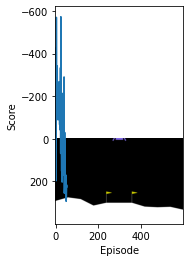

In [ ]:
environment, number_of_observations, number_of_actions = create_environment()
agent = DQN(number_of_observations, number_of_actions)
episode = 0
goal_reached = False
MAX_SCORE = 200 # Maximum score reacheable by the agent
start_time = time.perf_counter()
acc_reward_array = []
media = 0

while (episode < NUMBER_OF_EPISODES) and not (goal_reached):
    episode += 1
    step = 1
    end_episode = False
    acc_reward = 0
    state = environment.reset()
    screen_ini = environment.render(mode = 'rgb_array')
    plt.imshow(screen_ini)
    while not(end_episode):
        # Select an action for the current state
        action = agent.select(state)

        # Execute the action in the environment
        state_next, reward, terminal_state, info = environment.step(action)

        acc_reward += reward

        # Store in memory the transition (s,a,r,s') 
        agent.remember(state, action, reward, state_next, terminal_state)

        # Learn using a batch of experience stored in memory
        agent.learn()
  
        # Detect end of episode and print
        if terminal_state or acc_reward >= MAX_SCORE:
            agent.add_score(acc_reward)

            if episode%10 == 0:
              screen = environment.render(mode='rgb_array')
              plt.imshow(screen)
              ipythondisplay.display(plt.gcf())

            acc_reward_array.append(acc_reward)
            if episode >= 10:
              media = np.sum(acc_reward_array[-10:])/10
              if media >= 200: goal_reached = True
            print("Episode {0:>3}: ".format(episode), end = '')
            print("avg score {0:>3} ".format(media), end = '')
            print("last score {0:>3} ".format(acc_reward), end = '')  
            print("(exploration rate: %.2f, " % agent.exploration_rate, end = '')
            print("transitions: " + str(agent.memory.current_size) + ")")
            end_episode = True 
        else:
            state = state_next
            step += 1

if goal_reached: print("Reached goal successfully.")
else: print("Failure to reach the goal.")

print ("Time:", round((time.perf_counter() - start_time)/60), "minutes")

agent.display_scores_graphically()